<a href="https://colab.research.google.com/github/LiyangLiu123/DeepFall/blob/master/high_quality_sim/high_quality_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import argparse
import numpy as np


# def train_opts(parser):
#   parser.add_argument('--lr', type=float, default=2e-4,help='lr')
#   parser.add_argument('--batch_size', type=int, default=128, help='batch_size')
#   parser.add_argument('--seq_len', type=int, default=20)
#   parser.add_argument('--num_layers', type=int, default=6,help='num_layers')
#   parser.add_argument('--hidden_size', type=int, default=512)
#   parser.add_argument('--test_CV', action='store_true', default=False,help='use the CS test setting. If True, then use CV test setting.')
#   parser.add_argument('--use_weightdecay_nohiddenW', action='store_true', default=False)
#   parser.add_argument('--decayfactor', type=float, default=1e-4,help='lr')
#   parser.add_argument('--opti', type=str, default='adam')
#   parser.add_argument('--pThre', type=int, default=20)
#   parser.add_argument('--test_no', type=int, default=20)

#   parser.add_argument('--ini_in2hid', type=float, default=0.002)

#   parser.add_argument('--constrain_U', action='store_true', default=False)
#   parser.add_argument('--MAG', type=float, default=5.0)

#   parser.add_argument('--eval_fold', type=int, default=5)
#   parser.add_argument('--use_bneval', action='store_true', default=False)
#   parser.add_argument('--ini_b', type=float, default=0.0)
#   parser.add_argument('--end_rate', type=float, default=1e-6)
  
#   parser.add_argument('--dropout', type=float, default=0.1,help='lr')
  
lr = 2e-4
batch_size = 128
seq_len = 90
num_layers = 6
hidden_size = 512
use_weightdecay_nohiddenW = False
decay_factor = 1e-4
opti = 'adam'
pThre = 20
global_test_no = 1
ini_in2hid = 0.002
constrain_U = False
MAG = 5.0
eval_fold = 5
use_bneval = False
ini_b = 0.0
end_rate = 1e-6

dropout = 0.25
  
n_dimension = 2
num_joints = 18 # two skeletons with each 25 joints
outputclass = 2


train_link = 'https://drive.google.com/open?id=1u0yQ9_HpbSWr9bA_kk9JSYIEiIDtl0o0'
train_len_link = 'https://drive.google.com/open?id=1U2cpA5nAna6if8defEE47yM4NzNmYR5Q'
train_label_link = 'https://drive.google.com/open?id=1Yc_48Q1YNMuCXD0ZOGAUyYz8vuGT9wIC'
test_link = 'https://drive.google.com/open?id=1AQoAmDJiiamzk40g8xT3Ew1ZGfZqvwqw'
test_len_link = 'https://drive.google.com/open?id=1o6l6psaYxUEEz1ShRo-dbc54Zh5CsfFj'
test_label_link = 'https://drive.google.com/open?id=1pszo7gtCFm0nhKJRqdKW4fpNv2HJpwaf'

In [0]:
"""
This code is to implement the IndRNN (only the recurrent part). The code is based on the implementation from 
https://github.com/StefOe/indrnn-pytorch/blob/master/indrnn.py.
Since this only contains the recurrent part of IndRNN, fully connected layers or convolutional layers are needed before it.
Please cite the following paper if you find it useful.
Shuai Li, Wanqing Li, Chris Cook, Ce Zhu, and Yanbo Gao. "Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN," 
In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pp. 5457-5466. 2018.
@inproceedings{li2018independently,
  title={Independently recurrent neural network (indrnn): Building A longer and deeper RNN},
  author={Li, Shuai and Li, Wanqing and Cook, Chris and Zhu, Ce and Gao, Yanbo},
  booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition},
  pages={5457--5466},
  year={2018}
}
"""


import torch
from torch.nn import Parameter
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math


class IndRNNCell_onlyrecurrent(nn.Module):
    r"""An IndRNN cell with ReLU non-linearity. This is only the recurrent part where the input is already processed with w_{ih} * x + b_{ih}.

    .. math::
        input=w_{ih} * x + b_{ih}
        h' = \relu(input +  w_{hh} (*) h)
    With (*) being element-wise vector multiplication.

    Args:
        hidden_size: The number of features in the hidden state h

    Inputs: input, hidden
        - **input** (batch, input_size): tensor containing input features
        - **hidden** (batch, hidden_size): tensor containing the initial hidden
          state for each element in the batch.

    Outputs: h'
        - **h'** (batch, hidden_size): tensor containing the next hidden state
          for each element in the batch
    """

    def __init__(self, hidden_size, 
                 hidden_max_abs=None, recurrent_init=None):
        super(IndRNNCell_onlyrecurrent, self).__init__()
        self.hidden_size = hidden_size
        self.recurrent_init = recurrent_init
        self.weight_hh = Parameter(torch.Tensor(hidden_size))            
        self.reset_parameters()

    def reset_parameters(self):
        for name, weight in self.named_parameters():
            if "weight_hh" in name:
                if self.recurrent_init is None:
                    nn.init.uniform(weight, a=0, b=1)
                else:
                    self.recurrent_init(weight)

    def forward(self, input, hx):
        return F.relu(input + hx * self.weight_hh.unsqueeze(0).expand(hx.size(0), len(self.weight_hh)))


class IndRNN_onlyrecurrent(nn.Module):
    r"""Applies an IndRNN with `ReLU` non-linearity to an input sequence. 
    This is only the recurrent part where the input is already processed with w_{ih} * x + b_{ih}.


    For each element in the input sequence, each layer computes the following
    function:

    .. math::

        h_t = \relu(input_t +  w_{hh} (*) h_{(t-1)})

    where :math:`h_t` is the hidden state at time `t`, and :math:`input_t`
    is the input at time `t`. (*) is element-wise multiplication.

    Args:
        hidden_size: The number of features in the hidden state `h`
        batch_first: If ``True``, then the input and output tensors are provided
            as `(batch, seq, feature)`

    Inputs: input, h_0
        - **input** of shape `(seq_len, batch, input_size)`: tensor containing the features
          of the input sequence. The input can also be a packed variable length
          sequence. See :func:`torch.nn.utils.rnn.pack_padded_sequence`
          or :func:`torch.nn.utils.rnn.pack_sequence`
          for details.
        - **h_0** of shape `(num_directions, batch, hidden_size)`: tensor
          containing the initial hidden state for each element in the batch.
          Defaults to zero if not provided.

    Outputs: output, h_n
        - **output** of shape `(seq_len, batch, hidden_size * num_directions)`: tensor
          containing the output features (`h_k`) from the last layer of the RNN,
          for each `k`.  If a :class:`torch.nn.utils.rnn.PackedSequence` has
          been given as the input, the output will also be a packed sequence.
        - **h_n** (num_directions, batch, hidden_size): tensor
          containing the hidden state for `k = seq_len`.
    """

    def __init__(self, hidden_size, 
                 batch_first=False, bidirectional=False, recurrent_inits=None,
                 **kwargs):
        super(IndRNN_onlyrecurrent, self).__init__()
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional

        num_directions = 2 if self.bidirectional else 1

        if batch_first:
            self.time_index = 1
            self.batch_index = 0
        else:
            self.time_index = 0
            self.batch_index = 1

        cells = []
        directions = []
        if recurrent_inits is not None:
            kwargs["recurrent_init"] = recurrent_inits
        for dir in range(num_directions):
            directions.append(IndRNNCell_onlyrecurrent(hidden_size, **kwargs))
        self.cells = nn.ModuleList(directions)

        h0 = torch.zeros(hidden_size * num_directions)
        self.register_buffer('h0', torch.autograd.Variable(h0))

    def forward(self, x, hidden=None):
        time_index = self.time_index
        batch_index = self.batch_index
        num_directions = 2 if self.bidirectional else 1
        hidden_init = self.h0.unsqueeze(0).expand(
            x.size(batch_index),
            self.hidden_size * num_directions).contiguous()

        x_n = []
        for dir, cell in enumerate(self.cells):
            hx_cell = hidden_init[
                :, self.hidden_size * dir: self.hidden_size * (dir + 1)]
            outputs = []
            hiddens = []
            x_T = torch.unbind(x, time_index)
            if dir == 1:
                x_T = reversed(x_T)
            for x_t in x_T:
                hx_cell = cell(x_t, hx_cell)
                outputs.append(hx_cell)
            if dir == 1:
                outputs = outputs[::-1]
            x_cell = torch.stack(outputs, time_index)
            x_n.append(x_cell)
            hiddens.append(hx_cell)
        x = torch.cat(x_n, -1)
        return x.squeeze(2), torch.cat(hiddens, -1)


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fluff, train_id = train_link.split('=')
print (train_id) # Verify that you have everything after '='

fluff, train_len_id = train_len_link.split('=')
print (train_len_id) # Verify that you have everything after '='

fluff, train_label_id = train_label_link.split('=')
print (train_label_id) # Verify that you have everything after '='

fluff, test_id = test_link.split('=')
print (test_id) # Verify that you have everything after '='

fluff, test_len_id = test_len_link.split('=')
print (test_len_id) # Verify that you have everything after '='

fluff, test_label_id = test_label_link.split('=')
print (test_label_id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':train_id}) 
downloaded.GetContentFile('train.npy')

downloaded = drive.CreateFile({'id':train_len_id}) 
downloaded.GetContentFile('train_len.npy')

downloaded = drive.CreateFile({'id':train_label_id}) 
downloaded.GetContentFile('train_label.npy')

downloaded = drive.CreateFile({'id':test_id}) 
downloaded.GetContentFile('test.npy') 

downloaded = drive.CreateFile({'id':test_len_id}) 
downloaded.GetContentFile('test_len.npy') 

downloaded = drive.CreateFile({'id':test_label_id}) 
downloaded.GetContentFile('test_label.npy') 

train_datasets='train'
test_dataset='test'

1u0yQ9_HpbSWr9bA_kk9JSYIEiIDtl0o0
1U2cpA5nAna6if8defEE47yM4NzNmYR5Q
1Yc_48Q1YNMuCXD0ZOGAUyYz8vuGT9wIC
1AQoAmDJiiamzk40g8xT3Ew1ZGfZqvwqw
1o6l6psaYxUEEz1ShRo-dbc54Zh5CsfFj
1pszo7gtCFm0nhKJRqdKW4fpNv2HJpwaf


In [0]:
"""
This code is to implement the IndRNN (only the recurrent part) using CUDA for fast computation. The CUDA part is similar the SRU implementation from 
https://github.com/taolei87/sru.
This runs around 32 times faster than the general pytorch implementation on pixel MNIST example (sequence lengeth 784). For longer sequence, 
it will be even more efficient, and vice versa. 
Since this only contains the recurrent part of IndRNN, fully connected layers or convolutional layers are needed before it.
Please cite the following paper if you find it useful.
Shuai Li, Wanqing Li, Chris Cook, Ce Zhu, and Yanbo Gao. "Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN," 
In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pp. 5457-5466. 2018.
@inproceedings{li2018independently,
  title={Independently recurrent neural network (indrnn): Building A longer and deeper RNN},
  author={Li, Shuai and Li, Wanqing and Cook, Chris and Zhu, Ce and Gao, Yanbo},
  booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition},
  pages={5457--5466},
  year={2018}
}
"""
!pip install cupy
!pip install pynvrtc
import sys
import time
import math
#import warnings

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Function

from torch.nn import Parameter
#import torch.nn.functional as F

from cupy.cuda import function
from pynvrtc.compiler import Program
from collections import namedtuple

IndRNN_CODE = """
extern "C" {

    __forceinline__ __device__ float reluf(float x)
    {
        return (x > 0.f) ? x : 0.f;
    }

    __forceinline__ __device__ float calc_grad_activation(float x)
    {
        return (x > 0.f) ? 1.f : 0.f;
    }

    __global__ void indrnn_fwd( const float * __restrict__ x,
                            const float * __restrict__ weight_hh, const float * __restrict__ h0,
                            const int len, const int batch, const int hidden_size, 
                            float * __restrict__ h)
    {
        int ncols = batch*hidden_size;
        int col = blockIdx.x * blockDim.x + threadIdx.x;
        if (col >= ncols) return;       
        const float weight_hh_cur = *(weight_hh + (col%hidden_size));
        float cur = *(h0 + col);
        const float *xp = x+col;
        float *hp = h+col;

        for (int row = 0; row < len; ++row)
        {
            cur=reluf(cur*weight_hh_cur+(*xp));
            *hp=cur;
            xp += ncols;
            hp += ncols;            
        }
    }

    __global__ void indrnn_bwd(const float * __restrict__ x,
                             const float * __restrict__ weight_hh, const float * __restrict__ h0,
                             const float * __restrict__ h,
                            const float * __restrict__ grad_h, 
                            const int len, const int batch, const int hidden_size, 
                            float * __restrict__ grad_x,
                            float * __restrict__ grad_weight_hh, float * __restrict__ grad_h0)
    {    
        int ncols = batch*hidden_size;
        int col = blockIdx.x * blockDim.x + threadIdx.x;
        if (col >= ncols) return;        
        const float weight_hh_cur = *(weight_hh + (col%hidden_size));
        float gweight_hh_cur = 0;
        float cur = 0;  // *(grad_last + col);        //0; strange gradient behavior. grad_last and grad_h, one of them is zero.     
        
        const float *xp = x+col + (len-1)*ncols;
        const float *hp = h+col + (len-1)*ncols;      
        float *gxp = grad_x + col + (len-1)*ncols;
        const float *ghp = grad_h + col + (len-1)*ncols;
        

        for (int row = len-1; row >= 0; --row)
        {        
            const float prev_h_val = (row>0) ? (*(hp-ncols)) : (*(h0+col));
            //float h_val_beforeact = prev_h_val*weight_hh_cur+(*xp);
            float gh_beforeact = ((*ghp) + cur)*calc_grad_activation(prev_h_val*weight_hh_cur+(*xp));
            cur = gh_beforeact*weight_hh_cur;
            gweight_hh_cur += gh_beforeact*prev_h_val;
            *gxp = gh_beforeact;

            xp -= ncols;
            hp -= ncols;
            gxp -= ncols;
            ghp -= ncols;        
        }

        atomicAdd(grad_weight_hh + (col%hidden_size), gweight_hh_cur);
        *(grad_h0 +col) = cur;
    }
}
"""


class IndRNN_Compute_GPU(Function):

    _IndRNN_PROG = Program(IndRNN_CODE, 'indrnn_prog.cu')#.encode('utf-8')  .encode()
    _IndRNN_PTX = _IndRNN_PROG.compile()
    _DEVICE2FUNC = {}

    def __init__(self,gradclipvalue=0):
        super(IndRNN_Compute_GPU, self).__init__()
        self.gradclipvalue=gradclipvalue

    def compile_functions(self):
        device = torch.cuda.current_device()
        print ('IndRNN loaded for gpu {}'.format(device))
        mod = function.Module()
        mod.load(bytes(self._IndRNN_PTX.encode()))
        fwd_func = mod.get_function('indrnn_fwd')
        bwd_func = mod.get_function('indrnn_bwd')

        Stream = namedtuple('Stream', ['ptr'])
        current_stream = Stream(ptr=torch.cuda.current_stream().cuda_stream)

        self._DEVICE2FUNC[device] = (current_stream, fwd_func, bwd_func)
        return current_stream, fwd_func, bwd_func

    def get_functions(self):
        res = self._DEVICE2FUNC.get(torch.cuda.current_device(), None)
        return res if res else self.compile_functions()

    def forward(self, x, weight_hh, h0):
        length = x.size(0) if x.dim() == 3 else 1
        batch = x.size(-2)
        hidden_size = x.size(-1)  #hidden_size
        ncols = batch*hidden_size
        thread_per_block = min(512, ncols)
        num_block = (ncols-1)//thread_per_block+1
        
        size = (length, batch, hidden_size) if x.dim() == 3 else (batch, hidden_size)
        h = x.new(*size)

        stream, fwd_func, _ = self.get_functions()
        FUNC = fwd_func
        FUNC(args=[
            x.contiguous().data_ptr(),
            weight_hh.contiguous().data_ptr(),
            h0.contiguous().data_ptr(),
            length,
            batch,
            hidden_size,
            h.contiguous().data_ptr()],
            block = (thread_per_block,1,1), grid = (num_block,1,1),
            stream=stream
        )

        self.save_for_backward(x, h, weight_hh, h0)#
        return h

    def backward(self, grad_h):
        x, h, weight_hh, h0 = self.saved_tensors
        length = x.size(0) if x.dim() == 3 else 1
        batch = x.size(-2)
        hidden_size = x.size(-1)#self.hidden_size
        ncols = batch*hidden_size
        thread_per_block = min(512, ncols)
        num_block = (ncols-1)//thread_per_block+1

        grad_x = x.new(*x.size())
        grad_weight_hh = x.new(hidden_size).zero_()
        grad_h0 = x.new(batch, hidden_size)  

        stream, _, bwd_func = self.get_functions()
        FUNC = bwd_func
        FUNC(args=[
            x.contiguous().data_ptr(),
            weight_hh.contiguous().data_ptr(),
            h0.contiguous().data_ptr(),
            h.contiguous().data_ptr(),
            grad_h.contiguous().data_ptr(),
            length,
            batch,
            hidden_size,
            grad_x.contiguous().data_ptr(),
            grad_weight_hh.contiguous().data_ptr(),
            grad_h0.contiguous().data_ptr()],
            block = (thread_per_block,1,1), grid = (num_block,1,1),
            stream=stream
        )
        if self.gradclipvalue>0:
            grad_x.clamp_(-self.gradclipvalue,self.gradclipvalue)
            grad_weight_hh.clamp_(-self.gradclipvalue,self.gradclipvalue)
            grad_h0.clamp_(-self.gradclipvalue,self.gradclipvalue)
        return grad_x, grad_weight_hh, grad_h0




class cuda_IndRNN_onlyrecurrent(nn.Module):
    def __init__(self, hidden_size, gradclipvalue=0,
                 hidden_max_abs=None, recurrent_init=None):
        super(cuda_IndRNN_onlyrecurrent, self).__init__()
        self.hidden_size = hidden_size
        self.recurrent_init = recurrent_init
        self.weight_hh = Parameter(torch.Tensor(hidden_size))   
        self.gradclipvalue=gradclipvalue         
        self.reset_parameters()

    def reset_parameters(self):
        for name, weight in self.named_parameters():
            if "weight_hh" in name:
                if self.recurrent_init is None:
                    nn.init.uniform(weight, a=0, b=1)
                else:
                    self.recurrent_init(weight)

    def forward(self, input, h0=None):
        assert input.dim() == 2 or input.dim() == 3        
        if h0 is None:
            h0 = input.data.new(input.size(-2),input.size(-1)).zero_()
        IndRNN_Compute = IndRNN_Compute_GPU(self.gradclipvalue)
        #h=IndRNN_Compute(input, self.weight_hh, h0)
        return IndRNN_Compute(input, self.weight_hh, h0)


In [0]:
from __future__ import division
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_packed_sequence as unpack
from torch.nn.utils.rnn import pack_padded_sequence as pack
import torch.nn.init as weight_init
import torch.nn.functional as F
import numpy as np

#from cuda_IndRNN_onlyrecurrent import IndRNN_onlyrecurrent as IndRNN
#from IndRNN_onlyrecurrent import IndRNN_onlyrecurrent as IndRNN 
class Batch_norm_step(nn.Module):
    def __init__(self,  hidden_size,seq_len):
        super(Batch_norm_step, self).__init__()
        self.hidden_size = hidden_size
        
        self.max_time_step=seq_len
        self.bn = nn.BatchNorm1d(hidden_size) 

    def forward(self, x):
        x=x.permute(1,2,0)
        x= self.bn(x.clone())
        x=x.permute(2,0,1)
        return x
class Dropout_overtime(torch.autograd.Function):
  @staticmethod
  def forward(ctx, input, p=0.5,training=False):
    output = input.clone()
    noise = input.data.new(input.size(-2),input.size(-1))  #torch.ones_like(input[0])
    if training:            
      noise.bernoulli_(1 - p).div_(1 - p)
      noise = noise.unsqueeze(0).expand_as(input)
      output.mul_(noise)
    ctx.save_for_backward(noise)
    ctx.training=training
    return output
  @staticmethod
  def backward(ctx, grad_output):
    noise,=ctx.saved_tensors
    if ctx.training:
      return grad_output.mul(noise),None,None
    else:
      return grad_output,None,None
dropout_overtime=Dropout_overtime.apply

#import argparse
#import opts     
parser = argparse.ArgumentParser(description='pytorch action')
#train_opts(parser)
#args = parser.parse_args()
#MAG=args.MAG
U_bound=np.power(10,(np.log10(MAG)/seq_len))
U_lowbound=np.power(10,(np.log10(1.0/MAG)/seq_len))  
  
class stackedIndRNN_encoder(nn.Module):
    def __init__(self, input_size, outputclass):
        super(stackedIndRNN_encoder, self).__init__()        
        #hidden_size=args.hidden_size
        
        self.DIs=nn.ModuleList()
        denseinput=nn.Linear(input_size*n_dimension, hidden_size, bias=True)
        self.DIs.append(denseinput)
        for x in range(num_layers - 1):
            denseinput = nn.Linear(hidden_size, hidden_size, bias=True)
            self.DIs.append(denseinput)                
        
        self.BNs = nn.ModuleList()
        for x in range(num_layers):
            bn = Batch_norm_step(hidden_size,seq_len)
            self.BNs.append(bn)                      
  
        self.RNNs = nn.ModuleList()
        rnn = cuda_IndRNN_onlyrecurrent(hidden_size=hidden_size) #IndRNN
        self.RNNs.append(rnn)  
        for x in range(num_layers-1):
            rnn = cuda_IndRNN_onlyrecurrent(hidden_size=hidden_size) #IndRNN
            self.RNNs.append(rnn)         
            
        self.lastfc = nn.Linear(hidden_size, outputclass, bias=True)
        self.init_weights()

    def init_weights(self):
      for name, param in self.named_parameters():
        if 'weight_hh' in name:
          param.data.uniform_(0,U_bound)          
        if 'RNNs.'+str(num_layers-1)+'.weight_hh' in name:
          param.data.uniform_(U_lowbound,U_bound)    
        if 'DIs' in name and 'weight' in name:
          param.data.uniform_(-ini_in2hid,ini_in2hid)               
        if 'bns' in name and 'weight' in name:
          param.data.fill_(1)      
        if 'bias' in name:
          param.data.fill_(0.0)              
    def forward(self, input):
        all_output = []
        rnnoutputs={}
        hidden_x={}               
        seq_len, batch_size, indim,_=input.size()
             
        input=input.view(seq_len,batch_size,n_dimension*indim)                  
        for x in range(1,len(self.RNNs)+1):
          hidden_x['hidden%d'%x]=Variable(torch.zeros(1,batch_size,hidden_size).cuda())
                            
        rnnoutputs['rnnlayer0']=input
        for x in range(1,len(self.RNNs)+1):
          rnnoutputs['rnnlayer%d'%(x-1)]=rnnoutputs['rnnlayer%d'%(x-1)].view(seq_len*batch_size,-1)
          rnnoutputs['rnnlayer%d'%(x-1)]=self.DIs[x-1](rnnoutputs['rnnlayer%d'%(x-1)])   
          rnnoutputs['rnnlayer%d'%(x-1)]=rnnoutputs['rnnlayer%d'%(x-1)].view(seq_len,batch_size,-1)  
          rnnoutputs['rnnlayer%d'%x]= self.RNNs[x-1](rnnoutputs['rnnlayer%d'%(x-1)], hidden_x['hidden%d'%x])        
          rnnoutputs['rnnlayer%d'%x]=self.BNs[x-1](rnnoutputs['rnnlayer%d'%x])     
          if dropout>0:
            rnnoutputs['rnnlayer%d'%x]= dropout_overtime(rnnoutputs['rnnlayer%d'%x],dropout,self.training) 
        temp=rnnoutputs['rnnlayer%d'%len(self.RNNs)][-1]
        output = self.lastfc(temp)
        return output                


In [0]:
import sys
import h5py
import numpy as np
import time
import random
#import glob
#import skimage.transform
#from skimage import color
import pickle
#import theano
#import cv2
from multiprocessing import Pool
from threading import Thread
import os.path
#RGB_frames = '/home/sl669/caffe/colordataset/ImageNET/ILSVRC2015/Data/CLS-LOC/val/'#'/home/sl669/caffe/ucf101/framearrays/'#

#from __main__ import train_datasets
#train_datasets='train_ntus'
datasets=train_datasets
dataname=datasets+'.npy'
labelname=datasets+'_label.npy'
lenname=datasets+'_len.npy'
data_handle=np.load(dataname, allow_pickle=True)
label_handle=np.load(labelname, allow_pickle=True)
len_handle=np.load(lenname, allow_pickle=True)
num_videos = len(data_handle)  
train_no=int(num_videos*0.95)
test_no=num_videos-train_no

shufflevideolist=np.arange(num_videos)
np.random.shuffle(shufflevideolist)

shufflevideolist_train=shufflevideolist[:train_no]
shufflevideolist_test=shufflevideolist[train_no:]

print ('Dataset train size, eval size', train_no,test_no)


def rotate( input,s,b):
  shape=input.shape
  input=input.reshape((-1,3))
  XT=input[:,0]
  YT=input[:,1]
  ZT=input[:,2]
  s=s/180.0*np.pi
  b=b/180.0*np.pi
  RX = XT*np.cos(b) - ZT*np.sin(b) + ZT*np.sin(b)*np.cos(s) + YT*np.sin(b)*np.sin(s) - ZT*np.sin(b)*(np.cos(s) - 1);
  RY = YT*np.cos(s);
  RZ = ZT*np.cos(b)*np.cos(s) - ZT*(np.cos(b) - 1) - XT*np.sin(b) + YT*np.cos(b)*np.sin(s) - ZT*np.cos(b)*(np.cos(s) - 1);
  RX=RX.reshape((-1,1))
  RY=RY.reshape((-1,1))
  RZ=RZ.reshape((-1,1))
  output=np.concatenate([RX,RY,RZ],axis=1)
  output=output.reshape(shape)
  #print(shape,output.shape,input.shape)
  return output 

class batch_thread_train():
  def __init__(self, result, batch_size_,seq_len,use_rotation=False):
    self.result = result
    self.batch_size_=batch_size_
    self.seq_len=seq_len
    self.idx=0    
    self.use_rotation=use_rotation
  
  def __call__(self):###Be careful.  The appended data may change like pointer.
    templabel=[] 
    batch_data=[]
    for j in range(self.batch_size_):
      self.idx +=1
      if self.idx == train_no:
        self.idx =0
        np.random.shuffle(shufflevideolist_train)
      shufflevideoindex=shufflevideolist_train[self.idx]
      
      
      label=label_handle[shufflevideoindex]     
      templabel.append(np.int32(label))  
      dataset=data_handle[shufflevideoindex]
      len_data=len_handle[shufflevideoindex] 
      
      dataset = np.asarray(dataset)
      
      sample=np.zeros(tuple((self.seq_len,)+dataset.shape[1:]))
      lenperseg=len_data//self.seq_len
      if lenperseg==1 and len_data>self.seq_len:
        startid=np.random.randint(len_data-self.seq_len)
        sample=dataset[startid:startid+self.seq_len]
        #print('wrong data length first')
      elif len_data<=self.seq_len:
        startid=np.random.randint(max(self.seq_len-len_data,int(0.25*self.seq_len)))
        endid=min(self.seq_len,startid+len_data)
        datasid=0
        dataeid=len_data
        if startid+len_data>self.seq_len:
          datasid=np.random.randint(startid+len_data-self.seq_len)
          dataeid=datasid+self.seq_len-startid
        sample[startid:endid]=dataset[datasid:dataeid]
      else:      
        for framei in range(self.seq_len):        
          if framei==self.seq_len-1:
            index=lenperseg*framei + np.random.randint(len_data-lenperseg*(self.seq_len-1))
          else:
            index=lenperseg*framei + np.random.randint(lenperseg)    
          sample[framei]=dataset[index]
          
      
      if self.use_rotation:
        if np.random.randint(2):
          s=np.random.randint(2)*45#random(1)*45
          b=np.random.randint(2)*45#random(1)*45
          #print(sample.shape)
          sample=rotate(sample,s,b)
        #print (index,lenperseg)  
#       rframei=np.random.randint(len_data)  
#       tmean=(dataset[rframei,0,:]+dataset[rframei,12,:]+dataset[rframei,16,:])/3
#       sample=sample-tmean  
      batch_data.append(sample) ###Be careful. It has to be different. Otherwise, the appended data will change as well.
      #print(batch_data)  
    
      
    self.result['data']=np.asarray(batch_data,dtype=np.float32)
    self.result['label']= np.asarray(templabel,dtype=np.int32)
    

class DataHandler_train(object):

  def __init__(self, batch_size, seq_len, use_rotation=False):#datasets,
    self.batch_size_ = batch_size		
    #self.datasets = datasets    
    random.seed(10)  
    
    self.thread_result = {}
    self.thread = None

    self.batch_advancer =batch_thread_train(self.thread_result,self.batch_size_,seq_len,use_rotation)
    
    self.dispatch_worker()
    self.join_worker()


  def GetBatch(self):
    #self.batch_data_  = np.zeros((self.batch_size_, 3, self.seq_length_, 112, 112), dtype=np.float32)
    if self.thread is not None:
      self.join_worker() 

    self.batch_data_=self.thread_result['data']
    self.batch_label_= self.thread_result['label']
        
    self.dispatch_worker()
    return self.batch_data_, self.batch_label_

  def dispatch_worker(self):
    assert self.thread is None
    self.thread = Thread(target=self.batch_advancer)
    self.thread.start()

  def join_worker(self):
    assert self.thread is not None
    self.thread.join()
    self.thread = None
    
  def GetDatasetSize(self):
    return train_no




class batch_thread_eval():
  def __init__(self, result, batch_size_,seq_len):
    self.result = result
    self.batch_size_=batch_size_
    self.seq_len=seq_len
    self.idx=0    
  
  def __call__(self):###Be careful.  The appended data may change like pointer.
    templabel=[] 
    batch_data=[]
    for j in range(self.batch_size_):
      self.idx +=1
      if self.idx == test_no:
        self.idx =0
        np.random.shuffle(shufflevideolist_test)
      shufflevideoindex=shufflevideolist_test[self.idx]
      
      
      label=label_handle[shufflevideoindex]     
      templabel.append(np.int32(label))  
      dataset=data_handle[shufflevideoindex]
      len_data=len_handle[shufflevideoindex]
      
      dataset = np.asarray(dataset)
      
      sample=np.zeros(tuple((self.seq_len,)+dataset.shape[1:]))
      lenperseg=len_data//self.seq_len
      if lenperseg==1 and len_data>self.seq_len:
        startid=np.random.randint(len_data-self.seq_len)
        sample=dataset[startid:startid+self.seq_len]
      elif len_data<=self.seq_len:
        startid=np.random.randint(max(self.seq_len-len_data,int(0.25*self.seq_len)))
        endid=min(self.seq_len,startid+len_data)
        datasid=0
        dataeid=len_data
        if startid+len_data>self.seq_len:
          datasid=np.random.randint(startid+len_data-self.seq_len)
          dataeid=datasid+self.seq_len-startid
        sample[startid:endid]=dataset[datasid:dataeid]
      else:      
        for framei in range(self.seq_len):        
          if framei==self.seq_len-1:
            index=lenperseg*framei + np.random.randint(len_data-lenperseg*(self.seq_len-1))
          else:
            index=lenperseg*framei + np.random.randint(lenperseg)    
          sample[framei]=dataset[index]
        #print (index,lenperseg)  
        
      batch_data.append(sample) ###Be careful. It has to be different. Otherwise, the appended data will change as well.
      #print(batch_data)       
      
    self.result['data']=np.asarray(batch_data,dtype=np.float32)
    self.result['label']= np.asarray(templabel,dtype=np.int32)   

class DataHandler_eval(object):

  def __init__(self, batch_size, seq_len):#, datasets
    self.batch_size_ = batch_size    
    #self.datasets = datasets    
    random.seed(10)  
    
    self.thread_result = {}
    self.thread = None

    self.batch_advancer =batch_thread_eval(self.thread_result,self.batch_size_,seq_len)
    
    self.dispatch_worker()
    self.join_worker()


  def GetBatch(self):
    #self.batch_data_  = np.zeros((self.batch_size_, 3, self.seq_length_, 112, 112), dtype=np.float32)
    if self.thread is not None:
      self.join_worker() 

    self.batch_data_=self.thread_result['data']
    self.batch_label_= self.thread_result['label']
        
    self.dispatch_worker()
    return self.batch_data_, self.batch_label_

  def dispatch_worker(self):
    assert self.thread is None
    self.thread = Thread(target=self.batch_advancer)
    self.thread.start()

  def join_worker(self):
    assert self.thread is not None
    self.thread.join()
    self.thread = None
    
  def GetDatasetSize(self):
    return test_no


Dataset train size, eval size 18752 987


In [0]:
import sys
import h5py
import numpy as np
import time
import random
#import glob
#import skimage.transform
#from skimage import color
import pickle
#import theano
#import cv2
from multiprocessing import Pool
from threading import Thread
import os.path
#RGB_frames = '/home/sl669/caffe/colordataset/ImageNET/ILSVRC2015/Data/CLS-LOC/val/'#'/home/sl669/caffe/ucf101/framearrays/'#



#from __main__ import test_dataset
datasets=test_dataset
class batch_thread():
  def __init__(self, result, batch_size_,seq_len):#, datasets
    self.result = result
    self.batch_size_=batch_size_
    self.datasets = datasets   
    self.seq_len=seq_len
    self.idx=-1
    
    dataname=datasets+'.npy'
    labelname=datasets+'_label.npy'
    lenname=datasets+'_len.npy'
    self.data_handle=np.load(dataname, allow_pickle=True)
    self.label_handle=np.load(labelname, allow_pickle=True)
    self.len_handle=np.load(lenname, allow_pickle=True) 
    
    self.num_videos = len(self.data_handle)    
    self.shufflevideolist=np.arange(self.num_videos)
    np.random.shuffle(self.shufflevideolist)

    print ('Dataset test size', self.num_videos)
  
  def __call__(self):###Be careful.  The appended data may change like pointer.
    templabel=[] 
    batch_data=[]
    tempindex=[] 
    for j in range(self.batch_size_):
      self.idx +=1
      if self.idx == self.num_videos:
        self.idx =0
        np.random.shuffle(self.shufflevideolist)
      shufflevideoindex=self.shufflevideolist[self.idx]
      
      label=self.label_handle[shufflevideoindex]     
      templabel.append(np.int32(label))  
      tempindex.append(np.int32(shufflevideoindex)) 
      dataset=self.data_handle[shufflevideoindex]
      len_data=self.len_handle[shufflevideoindex] 
      
      dataset = np.asarray(dataset)
      
      sample=np.zeros(tuple((self.seq_len,)+dataset.shape[1:]))
      lenperseg=len_data//self.seq_len
      if lenperseg==1 and len_data>self.seq_len:
        startid=np.random.randint(len_data-self.seq_len)
        sample=dataset[startid:startid+self.seq_len]
      elif len_data<=self.seq_len:
        startid=np.random.randint(max(self.seq_len-len_data,int(0.25*self.seq_len)))
        endid=min(self.seq_len,startid+len_data)
        datasid=0
        dataeid=len_data
        if startid+len_data>self.seq_len:
          datasid=np.random.randint(startid+len_data-self.seq_len)
          dataeid=datasid+self.seq_len-startid
        sample[startid:endid]=dataset[datasid:dataeid]
      else:      
        for framei in range(self.seq_len):        
          if framei==self.seq_len-1:
            index=lenperseg*framei + np.random.randint(len_data-lenperseg*(self.seq_len-1))
          else:
            index=lenperseg*framei + np.random.randint(lenperseg)    
          sample[framei]=dataset[index]
        #print (index,lenperseg)  
        
      batch_data.append(sample) ###Be careful. It has to be different. Otherwise, the appended data will change as well.
      #print(batch_data)       

       
    self.result['data']=np.asarray(batch_data,dtype=np.float32)
    self.result['label']= np.asarray(templabel,dtype=np.int32)   
    self.result['index']= np.asarray(tempindex,dtype=np.int32)   
      
      
  def GetDatasetSize(self):
    return self.num_videos



class testDataHandler(object):

  def __init__(self, batch_size, seq_len):#, datasets
    self.batch_size_ = batch_size		
    #self.datasets = datasets    
    random.seed(10)  
    
    self.thread_result = {}
    self.thread = None

    self.batch_advancer =batch_thread(self.thread_result,self.batch_size_,seq_len)#, self.datasets
    
    self.datasetsize=self.batch_advancer.GetDatasetSize()
    
    self.dispatch_worker()
    self.join_worker()


  def GetBatch(self):
    #self.batch_data_  = np.zeros((self.batch_size_, 3, self.seq_length_, 112, 112), dtype=np.float32)
    if self.thread is not None:
      self.join_worker() 
      
#     self.batch_data_=self.thread_result['data']
#     self.batch_label_=self.thread_result['label']

    self.batch_data_=self.thread_result['data']
    self.batch_label_= self.thread_result['label']
    self.batch_index_= self.thread_result['index']
        
    self.dispatch_worker()
    return self.batch_data_, self.batch_label_,self.batch_index_


    


  def dispatch_worker(self):
    assert self.thread is None
    self.thread = Thread(target=self.batch_advancer)
    self.thread.start()

  def join_worker(self):
    assert self.thread is not None
    self.thread.join()
    self.thread = None
    
  def GetDatasetSize(self):
    return self.datasetsize

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def get_confusion_matrix(y_true, y_pred, classes,
                          normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    label_exist = [0]*len(classes)
    missing_labels = []
    for l in y_pred:
      label_exist[l]=1
    for l in y_true:
      label_exist[l]=1
    for i in range(len(classes)):
      if label_exist[i] is 0:
        if i not in missing_labels:
          missing_labels.append(i)
      
    missing_labels.sort()
    for l in missing_labels:
      cm = np.insert(cm,l,0,axis=0)
      cm = np.insert(cm,l,0,axis=1)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    return cm
    

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues, title=None, 
                          normalize=False):
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:224: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


Dataset test size 2575
Epoch:  1
IndRNN loaded for gpu 0
training accuracy:  0.649609375
training accuracy:  0.733203125
training accuracy:  0.790625
training accuracy:  0.80390625
training accuracy:  0.833984375
training accuracy:  0.860546875
training accuracy:  0.871484375
eval accuracy:  0.8923828125


Epoch:  2
training accuracy:  0.891796875
training accuracy:  0.907421875
training accuracy:  0.90546875
training accuracy:  0.909765625
training accuracy:  0.92578125
training accuracy:  0.91953125
training accuracy:  0.928515625
eval accuracy:  0.948046875


Epoch:  3
training accuracy:  0.93046875
training accuracy:  0.934375
training accuracy:  0.94140625
training accuracy:  0.939453125
training accuracy:  0.943359375
training accuracy:  0.94765625
training accuracy:  0.929296875
eval accuracy:  0.93984375


Epoch:  4
training accuracy:  0.94453125
training accuracy:  0.947265625
training accuracy:  0.95234375
training accuracy:  0.941015625
training accuracy:  0.94609375
trainin

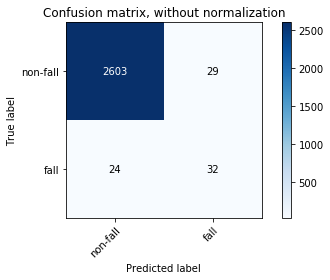

test accuracy:  0.9802827380952381 eval accuracy:  0.9798058252427184 ( use_bn_trainstat= False )


Epoch:  63
training accuracy:  0.993359375
training accuracy:  0.99296875
training accuracy:  0.995703125
training accuracy:  0.996484375
training accuracy:  0.99609375
training accuracy:  0.997265625
training accuracy:  0.9953125
eval accuracy:  0.9982421875


Epoch:  64
training accuracy:  0.994921875
training accuracy:  0.994921875
training accuracy:  0.9953125
training accuracy:  0.9953125
training accuracy:  0.995703125
training accuracy:  0.995703125
training accuracy:  0.995703125
eval accuracy:  0.9990234375


Epoch:  65
training accuracy:  0.9921875
training accuracy:  0.99453125
training accuracy:  0.995703125
training accuracy:  0.99453125
training accuracy:  0.9953125
training accuracy:  0.994921875
training accuracy:  0.9953125
eval accuracy:  0.998828125


Epoch:  66
training accuracy:  0.995703125
training accuracy:  0.994140625
training accuracy:  0.995703125
training acc

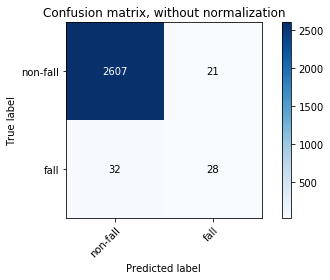

test accuracy:  0.9802827380952381 eval accuracy:  0.9829126213592233 ( use_bn_trainstat= False )


Epoch:  86
training accuracy:  0.997265625
training accuracy:  0.9953125
training accuracy:  0.996875
training accuracy:  0.997265625
training accuracy:  0.99609375
training accuracy:  0.9953125
training accuracy:  0.997265625
eval accuracy:  0.998046875


Epoch:  87
training accuracy:  0.99765625
training accuracy:  0.996484375
training accuracy:  0.997265625
training accuracy:  0.997265625
training accuracy:  0.997265625
training accuracy:  0.995703125
training accuracy:  0.99609375
eval accuracy:  0.99921875


Epoch:  88
training accuracy:  0.994140625
training accuracy:  0.99453125
training accuracy:  0.993359375
training accuracy:  0.996484375
training accuracy:  0.997265625
training accuracy:  0.997265625
training accuracy:  0.997265625
eval accuracy:  0.9982421875


Epoch:  89
training accuracy:  0.995703125
training accuracy:  0.99609375
training accuracy:  0.99609375
training ac

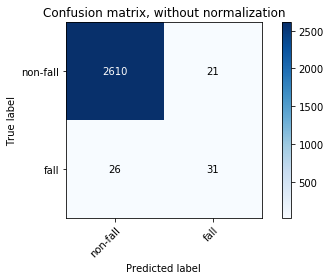

test accuracy:  0.9825148809523809 eval accuracy:  0.9844660194174757 ( use_bn_trainstat= False )


In [0]:
from __future__ import print_function
import sys
#import argparse
import os
import time
import numpy as np
import copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


# Set the random seed manually for reproducibility.
seed=100
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  pass
else:
  print("WARNING: CUDA not available")

#import opts     
#parser = argparse.ArgumentParser(description='pytorch action')
#opts.train_opts(parser)
#args = parser.parse_args()
#print(args)

#import Indrnn_action_network

#batch_size = args.batch_size
#seq_len=args.seq_len
in_size=num_joints
gradientclip_value=10
#U_bound=Indrnn_action_network.U_bound



model = stackedIndRNN_encoder(in_size, outputclass)  
model.cuda()
criterion = nn.CrossEntropyLoss()

#Adam with lr 2e-4 works fine.
learning_rate=lr
if use_weightdecay_nohiddenW:
  param_decay=[]
  param_nodecay=[]
  for name, param in model.named_parameters():
    if 'weight_hh' in name or 'bias' in name:
      param_nodecay.append(param)      
      #print('parameters no weight decay: ',name)          
    else:
      param_decay.append(param)      
      #print('parameters with weight decay: ',name)          

  if opti=='sgd':
    optimizer = torch.optim.SGD([
            {'params': param_nodecay},
            {'params': param_decay, 'weight_decay': decayfactor}
        ], lr=learning_rate,momentum=0.9,nesterov=True)   
  else:                
    optimizer = torch.optim.Adam([
            {'params': param_nodecay},
            {'params': param_decay, 'weight_decay': decayfactor}
        ], lr=learning_rate) 
else:  
  if opti=='sgd':   
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate,momentum=0.9,nesterov=True)
  else:                      
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
  
#from data_reader_numpy_witheval import DataHandler_train,DataHandler_eval  
#from data_reader_numpy_test import DataHandler as testDataHandler
dh_train = DataHandler_train(batch_size,seq_len)
dh_eval = DataHandler_eval(batch_size,seq_len)
dh_test= testDataHandler(batch_size,seq_len)
num_train_batches=int(np.ceil(dh_train.GetDatasetSize()/(batch_size+0.0)))
num_eval_batches=int(np.ceil(dh_eval.GetDatasetSize()/(batch_size+0.0)))
num_test_batches=int(np.ceil(dh_test.GetDatasetSize()/(batch_size+0.0)))
#print(num_train_batches)


def train(num_train_batches):
  model.train()
  tacc=0
  count=0
  start_time = time.time()
  for batchi in range(0,num_train_batches):
    inputs,targets=dh_train.GetBatch()
    #print(inputs.shape)
    inputs=inputs.transpose(1,0,2,3)
    
    
    inputs=Variable(torch.from_numpy(inputs).cuda(), requires_grad=True)
    targets=Variable(torch.from_numpy(np.int64(targets)).cuda(), requires_grad=False)

    model.zero_grad()
    if constrain_U:
      clip_weight(model,U_bound)
    output=model(inputs)
    loss = criterion(output, targets)

    pred = output.data.max(1)[1] # get the index of the max log-probability
    accuracy = pred.eq(targets.data).cpu().sum().numpy()/(0.0+targets.size(0))      
          
    loss.backward()
    clip_gradient(model,gradientclip_value)
    optimizer.step()
    
    tacc=tacc+accuracy#loss.data.cpu().numpy()#accuracy
    count+=1
  elapsed = time.time() - start_time
  print ("training accuracy: ", tacc/(count+0.0)  )
  #print ('time per batch: ', elapsed/num_train_batches)
  #print ('time per epoch: ', elapsed)
  
def set_bn_train(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
      m.train()       
def eval(dh,num_batches,use_bn_trainstat=False):
  model.eval()
  if use_bn_trainstat:
    model.apply(set_bn_train)
  tacc=0
  count=0  
  start_time = time.time()
  while(1):  
    inputs,targets=dh.GetBatch()
    inputs=inputs.transpose(1,0,2,3)
    inputs=Variable(torch.from_numpy(inputs).cuda())
    targets=Variable(torch.from_numpy(np.int64(targets)).cuda())
        
    output=model(inputs)
    pred = output.data.max(1)[1] # get the index of the max log-probability
    accuracy = pred.eq(targets.data).cpu().sum().numpy()        
    tacc+=accuracy
    count+=1
    if count==num_batches*eval_fold:
      break
  elapsed = time.time() - start_time
  print ("eval accuracy: ", tacc/(count*targets.data.size(0)+0.0)  )
  #print ('eval time per batch: ', elapsed/(count+0.0))
  return tacc/(count*targets.data.size(0)+0.0)


def test(dh,num_batches,use_bn_trainstat=False, save_cm=False):
  model.eval()
  if use_bn_trainstat:
    model.apply(set_bn_train)
  tacc=0
  count=0  
  start_time = time.time()
  total_testdata=dh.GetDatasetSize()  
  total_ave_acc=np.zeros((total_testdata,outputclass))
  testlabels=np.zeros((total_testdata))
  #print("number of tests: ", test_no)
  cm = np.zeros((outputclass,outputclass)).astype(int)
  if outputclass is 2:
    class_names = np.array(['non-fall', 'fall'])
  else:
    class_names = np.array(range(60))
  while(1):  
    inputs,targets,index=dh.GetBatch()
    inputs=inputs.transpose(1,0,2,3)
    testlabels[index]=targets
    inputs=Variable(torch.from_numpy(inputs).cuda())
    targets=Variable(torch.from_numpy(np.int64(targets)).cuda())
        
    output=model(inputs)
    pred = output.data.max(1)[1] # get the index of the max log-probability
    accuracy = pred.eq(targets.data).cpu().sum().numpy()    
    total_ave_acc[index]+=output.data.cpu().numpy()

    # Plot non-normalized confusion matrix
    cm += get_confusion_matrix(targets.cpu().data.cpu().numpy().astype(int), pred.cpu().data.cpu().numpy().astype(int), classes=class_names)
    
    tacc+=accuracy
    count+=1
    if count==global_test_no*num_batches:
      break    
  #total_ave_acc/=args.test_no
  np.set_printoptions(precision=2)
  plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')
  plt.show()
  
  if save_cm:
    np.save('cm.npy',cm)
    model_file = drive.CreateFile({'title' : 'cm.npy'})
    model_file.SetContentFile('cm.npy')
    model_file.Upload()

    # download to google drive
    drive.CreateFile({'id': model_file.get('id')})


  top = np.argmax(total_ave_acc, axis=-1)
  eval_acc=np.mean(np.equal(top, testlabels))    
  elapsed = time.time() - start_time
  print ("test accuracy: ", tacc/(count*targets.data.size(0)+0.0), "eval accuracy: ", eval_acc, "( use_bn_trainstat=", use_bn_trainstat, ")"  )
  #print ('test time per batch: ', elapsed/(count+0.0))
  
  
  return tacc/(count*targets.data.size(0)+0.0)#, eval_acc/(total_testdata+0.0)

def clip_gradient(model, clip):
    for p in model.parameters():
        p.grad.data.clamp_(-clip,clip)
        #print(p.size(),p.grad.data)

def adjust_learning_rate(optimizer, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr     

def clip_weight(RNNmodel, clip):
    for name, param in RNNmodel.named_parameters():
      if 'weight_hh' in name:
        param.data.clamp_(-clip,clip)
    
lastacc=0
eval_dispFreq=20
patience=0
reduced=1
for i in range(1,301):
  print("Epoch: ", i)
  for _ in range(num_train_batches//eval_dispFreq):
    train(eval_dispFreq)
  test_acc=eval(dh_eval,num_eval_batches,use_bneval)

  model_clone = copy.deepcopy(model.state_dict())
  opti_clone = copy.deepcopy(optimizer.state_dict())
  if (test_acc >lastacc):  
    lastacc=test_acc
    patience=0
  elif patience>int(pThre/reduced+0.5):
    reduced=reduced*2
    print ('learning rate',learning_rate)
    model.load_state_dict(model_clone)
    optimizer.load_state_dict(opti_clone)
    patience=0
    learning_rate=learning_rate*0.1
    adjust_learning_rate(optimizer,learning_rate)     
    if learning_rate<end_rate:
      break  
    test_acc=test(dh_test,num_test_batches)     
 
  else:
    patience+=1 
  print('\n')
    
test_acc=test(dh_test,num_test_batches)  
#test_acc=test(dh_test,num_test_batches,True)   